In [ ]:
from functools import partial
import os
import sys
import time
import numpy as np
from sigwfast import sigwfast_mod as gw
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from nautilus import Sampler
import math
import h5py
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

OMEGA_R = 4.2 * 10**(-5)
CG = 0.39
rd_norm = CG * OMEGA_R 
nd = 150
SQRTEPS = math.sqrt(float(np.finfo(np.float64).eps))

from libraries import sdintegral_numba as sd

from collections import OrderedDict

# Global cache for storing kernels keyed by rounded w
kernel_cache = OrderedDict()

cache_counter = 0

# open once, reuse for all likelihood calls
h5 = h5py.File("precomputed_kernels.h5", "r")
w_vals = h5["w_vals"][:]      # load in memory once; it's small
# kernel datasets stay on disk until you index them
dset1 = h5["kernel1"]
dset2 = h5["kernel2"]
tol = 1e-3

def get_kernels_from_file(w):
    # find index of the closest precomputed w
    idx = np.abs(w_vals - w).argmin()
    # print(f"Closest precomputed w: {w_vals[idx]:.6f} (target: {w:.6f})")
    if abs(w_vals[idx] - w) > tol:
        raise ValueError(f"No precomputed w within ±{tol}: nearest is {w_vals[idx]:.6f}")
    # pull the two rows
    k1 = dset1[idx, :]
    k2 = dset2[idx, :]
    return k1, k2

def compute_w(w,log10_f_rh,nodes,vals,lengthscale,
              frequencies,pk_arr,nd=150,fref=1.,kernels_from_file=True):
    global cache_counter
    nd,ns1,ns2, darray,d1array,d2array, s1array,s2array = sd.arrays_w(w,frequencies,nd=nd)
    b = sd.beta(w)

    if kernels_from_file:
        try:
            kernel1, kernel2 = get_kernels_from_file(w,)
            cache_counter += 1
        except:
            # If the kernel is not found in the file, compute it
            kernel1, kernel2 = sd.kernel1_w(d1array, s1array, b), sd.kernel2_w(d2array, s2array, b)
    else:
        kernel1, kernel2 = sd.kernel1_w(d1array, s1array, b), sd.kernel2_w(d2array, s2array, b)

    gpkernel = 1 * RBF(length_scale=lengthscale, length_scale_bounds="fixed") #+ np.eye(len(nodes)) * 1e-10
    gaussian_process = GaussianProcessRegressor(kernel=gpkernel, optimizer=None, normalize_y=True)
    gaussian_process.fit(nodes.reshape(-1, 1),vals)

    interp_nodes = np.linspace(nodes[0], nodes[-1], 100)
    interp_vals = gaussian_process.predict(interp_nodes.reshape(-1, 1))

    pz_amps = gw.power_spectrum_k_array(interp_nodes,interp_vals,pk_arr)

    # print(f"Shapes interpolated nodes and vals: {interp_nodes.shape}, {interp_vals.shape}")

    nk = len(frequencies)
    Integral = np.empty_like(frequencies)
    Integral = gw.compute_w_k_array(nodes = interp_nodes, vals = interp_vals, nk = nk,komega = frequencies, 
                                            kernel1 = kernel1, kernel2 = kernel2, d1array=d1array,
                                            s1array=s1array, d2array=d2array, s2array=s2array,
                                            darray=darray, nd = nd, ns1 = ns1, ns2 = ns2)
    f_rh = 10**log10_f_rh
    two_b = 2*b
    norm = rd_norm * (frequencies)**(-2*b) *  (f_rh/fref)**(two_b)   
    OmegaGW = norm * Integral
    return OmegaGW, pz_amps

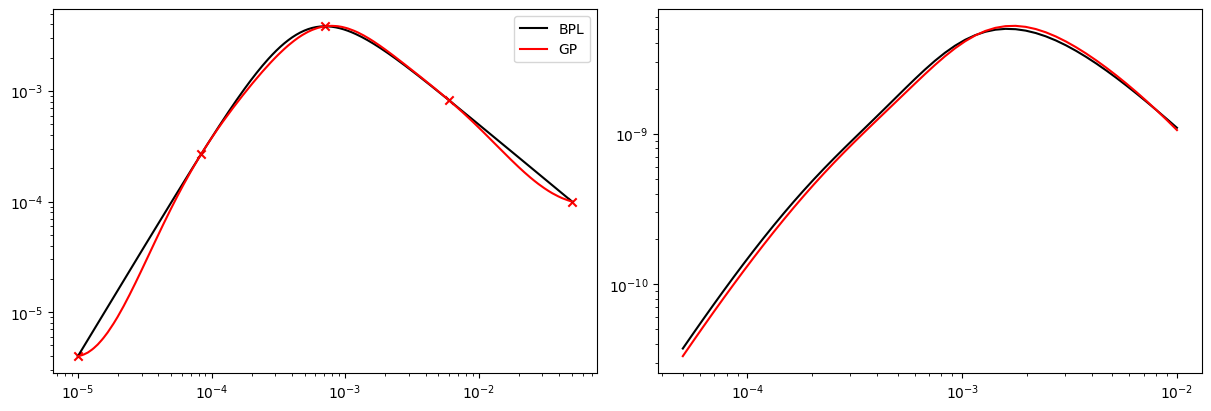

In [21]:
data = np.load('./spectra_0p66_interp.npz')
frequencies = data['frequencies']
Omegas = data['gw_bpl']

def bpl(p, pstar=5e-4, n1=2, n2=-1, sigma=2):
    nir = n1
    pl1 = (p / pstar) ** nir
    nuv = (n2 - n1) / sigma
    pl2 = (1 + (p / pstar) ** sigma) ** nuv
    return 1e-2 * pl1 * pl2

fac = 5.
pk_min, pk_max = np.array(min(frequencies)/fac), np.array(max(frequencies)*fac)
pk_arr = np.geomspace(pk_min, pk_max, 250)
num_nodes = 5
w = 2/3
log10_f_rh = -5

nodes = np.log10(np.geomspace(pk_min, pk_max, num_nodes))
vals = np.log10(bpl(10**nodes, pstar=5e-4, n1=2, n2=-1, sigma=2))
l = 0.5

omgw_bpl,pz_amp = compute_w(w,log10_f_rh,nodes,vals,lengthscale=l,frequencies=frequencies, pk_arr = pk_arr,nd=150)


fig, ax = plt.subplots(1,2,figsize=(12,4),constrained_layout=True)
ax[0].loglog(pk_arr,bpl(pk_arr), label='BPL', color='black')
ax[0].loglog(pk_arr, pz_amp, label='GP', color='red')
ax[0].scatter(10**nodes, 10**vals, color='red', marker='x')
ax[0].legend()

ax[1].loglog(frequencies,Omegas, label='BPL', color='black')
ax[1].loglog(frequencies, omgw_bpl, label='GP', color='red')